# Notes

# Libraries

In [45]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set(font_scale=1)
import matplotlib.pyplot as plt

# Load Data

In [46]:
# Data reading OK
print(os.listdir("../home-data-for-ml-course"))

['train.csv.gz', 'sample_submission.csv', 'sample_submission.csv.gz', 'home-data-for-ml-course-publicleaderboard.csv', 'data_description.txt', 'test.csv.gz', 'test.csv', 'train.csv']


In [47]:
# Loading data

train=pd.read_csv('../home-data-for-ml-course/train.csv')
test=pd.read_csv('../home-data-for-ml-course/test.csv')

# Data Analysis

In [48]:
# Data look up
train.drop('Id',axis=1, inplace=True)
# do not drop test id
#test.drop('Id',axis=1, inplace=True)
train.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

## Treating NaN values

In [50]:
# Calculating NaN percentage
def nans_ratio(train):
    """calculate the nan ratio in a df"""
    total_nans = train.isna().sum().sum()
    total_cells = train.count().sum()
    nans_ratio = total_nans / total_cells
    return nans_ratio
nans_ratio(train)*100

6.341330177083808

### Alley

In [51]:
# the data description indicates that NA as 'No alley' ot 'Not Apply', so we will turn this NaN into 'NA'
train['Alley'].value_counts()

Grvl    50
Pave    41
Name: Alley, dtype: int64

In [52]:
train['Alley'].fillna('NA', inplace=True)
train['Alley'].value_counts()

NA      1369
Grvl      50
Pave      41
Name: Alley, dtype: int64

### Other features

In [53]:
# The same problems was founded in several features that include 'NA' in it's values
# NaN values will be replaced with 'NA' in the following features
nan_features = ['Alley','FireplaceQu', 'PoolQC','Fence','MiscFeature','GarageType','GarageFinish','GarageQual',
                'GarageCond','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']
for f in nan_features:
    train[f].fillna('NA', inplace=True)
    test[f].fillna('NA', inplace=True)
    #don't forget to assign the new col to itself

In [54]:
train['PoolQC'].value_counts()

NA    1453
Gd       3
Ex       2
Fa       2
Name: PoolQC, dtype: int64

In [55]:
# For 'GarageYrBlt', if there is no garage, it will be filled with 0
# The same will be donde for 'LotFrontage', assuming that NaN is equalo to 0 or no front.
train['GarageYrBlt'].fillna(0, inplace=True)
test['GarageYrBlt'].fillna(0, inplace=True)
train['LotFrontage'].fillna(0, inplace=True)
test['LotFrontage'].fillna(0, inplace=True)

In [56]:
# for the test set, due to submission requirements, i will not drop the rows with nan
# instead , I will fill the nan values with the mode

# LOOK WAYS TO MAKE THIS BETTER. I.e. fill with the median/mode of a feature taking in account it relation
# with other feature ( group_by etc)

for i in test.columns:
    if test[i].isna().any():
        test[i]=test[i].fillna(test[i].mode()[0])

In [57]:
# Check info
nans_ratio(train)*100

0.014556913249359925

### Drop the rest of the NaN rows

To avoid further problems, the rest of the Nulls/Nans rows of the train set will be droped

In [58]:
# Train
train = train.dropna()
train = train.reset_index(drop=True)


In [59]:
nans_ratio(train)


0.0

## Treating categorical data

Because there are son many features with categorical data, using dummy for all variables will leave the df with hundreds columns more.
Also, many of the categorical features have some ordinal properties, so we want to keep that information. Variables will be processed to asign numerical values going from 0 (worst) to n (best) (n=number of labels)

I.e. 

AllPub	All public Utilities (E,G,W,& S)	-->3

NoSewr	Electricity, Gas, and Water (Septic Tank) -->2

NoSeWa	Electricity and Gas Only  --> 1

ELO	Electricity only	--> 0

This process will be done automatically, grouping by the feature and ranking by the mean of the target (SalePrice).

For more info, look at data_description.txt

### Categorical encoding function


In [60]:
#SalePrice-> group_by MSZoning -> mean
train.groupby('MSZoning')['SalePrice'].mean().sort_values(ascending=True)

MSZoning
C (all)     74528.000000
RM         126316.830275
RH         131558.375000
RL         190720.720524
FV         214888.129032
Name: SalePrice, dtype: float64

In [61]:
train["Utilities"].value_counts()

AllPub    1450
NoSeWa       1
Name: Utilities, dtype: int64

In [62]:
train["MSZoning"].value_counts()

RL         1145
RM          218
FV           62
RH           16
C (all)      10
Name: MSZoning, dtype: int64

In [63]:
labels = train.groupby('MSZoning')['SalePrice'].mean().sort_values(ascending=True).index
labels

Index(['C (all)', 'RM', 'RH', 'RL', 'FV'], dtype='object', name='MSZoning')

In [64]:
for i,label in enumerate(labels):
    train.loc[train["MSZoning"] == label, "MSZoning"] = int(i)
    test.loc[test["MSZoning"] == label, "MSZoning"] = int(i)
train["MSZoning"] = train["MSZoning"].astype(int)
test["MSZoning"] = test["MSZoning"].astype(int)

In [65]:
train["MSZoning"].value_counts()

3    1145
1     218
4      62
2      16
0      10
Name: MSZoning, dtype: int64

In [66]:
def encode_categorical(feature):
    """
    Giving a feature f, encodes the categorical feature
    into integers from 0 to n-1 taking in account the 
    correlation with the target SalePrice
    """
    labels = train.groupby(feature)['SalePrice'].mean().sort_values(ascending=True).index
    for i,label in enumerate(labels):
        train.loc[train[feature] == label, feature] = i
        test.loc[test[feature] == label, feature] = i
    train[feature] = train[feature].astype(int)
    test[feature] = test[feature].astype(int)

## Ordinal categorical encoding

In [67]:
# Encoding train and test df

for column in train.columns:
    # if the dtype of the column is object
    if train[column].dtype == 'object':
        # encodes both train and test
        encode_categorical(column)
        
# Re-encoding MSSubClass
encode_categorical('MSSubClass')

In [68]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1459 non-null   int64  
 3   LotFrontage    1459 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   int64  
 6   Alley          1459 non-null   int64  
 7   LotShape       1459 non-null   int64  
 8   LandContour    1459 non-null   int64  
 9   Utilities      1459 non-null   int64  
 10  LotConfig      1459 non-null   int64  
 11  LandSlope      1459 non-null   int64  
 12  Neighborhood   1459 non-null   int64  
 13  Condition1     1459 non-null   int64  
 14  Condition2     1459 non-null   int64  
 15  BldgType       1459 non-null   int64  
 16  HouseStyle     1459 non-null   int64  
 17  OverallQual    1459 non-null   int64  
 18  OverallC

## Dealing with outlier and non usefull features

### Visualizing data

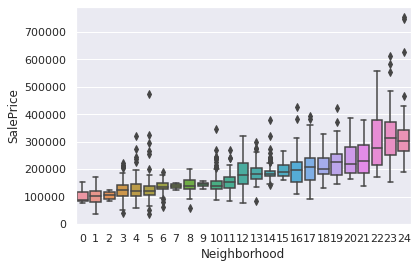

In [69]:
sns.boxplot(x='Neighborhood',y='SalePrice',data=train);
plt.savefig('scatter_Neighborhood_SalePrice.png')

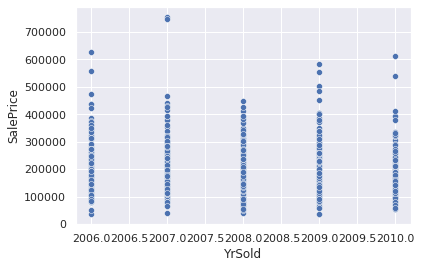

In [72]:
sns.scatterplot(x='YrSold',y='SalePrice',data=train);
plt.savefig('scatter_YrSold_SalePrice.png')

/tmp/ipykernel_30643/1275443494.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i)


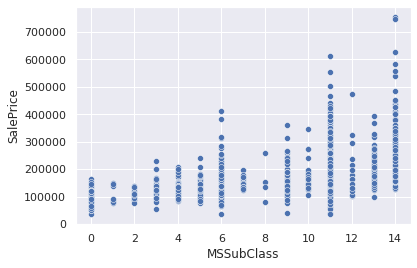

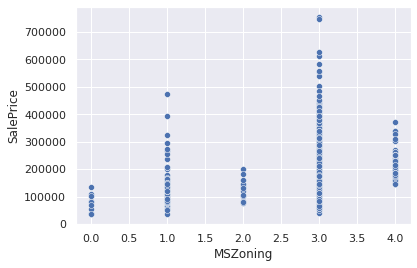

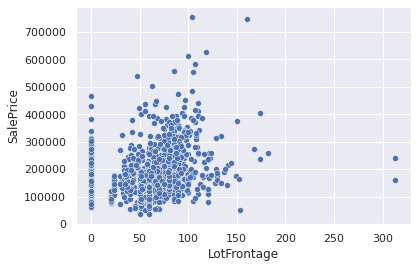

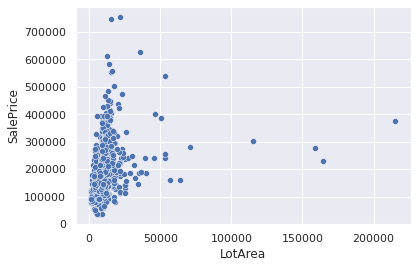

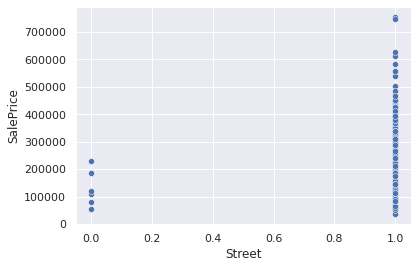

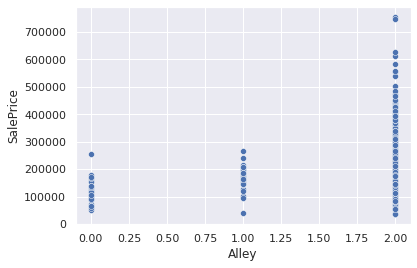

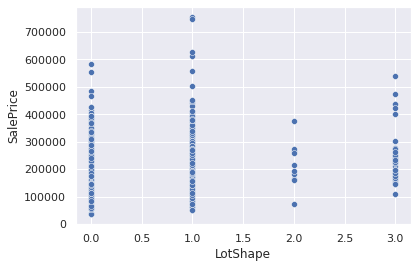

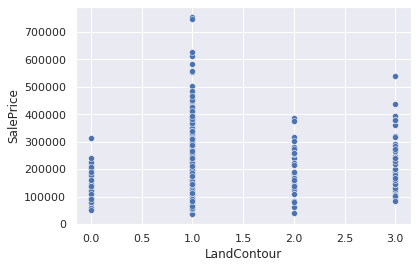

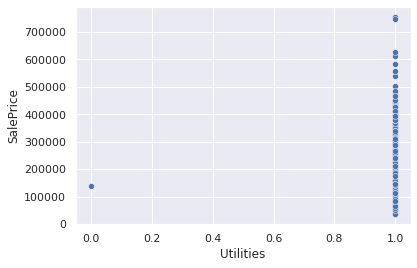

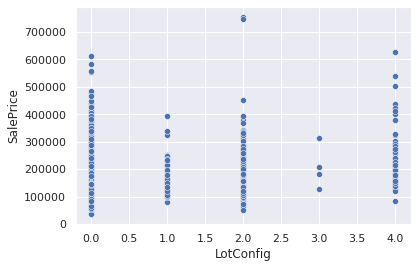

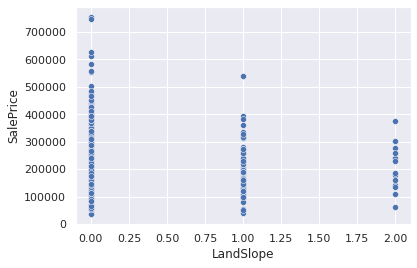

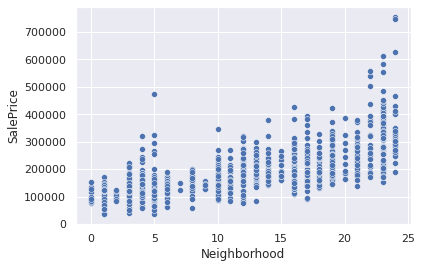

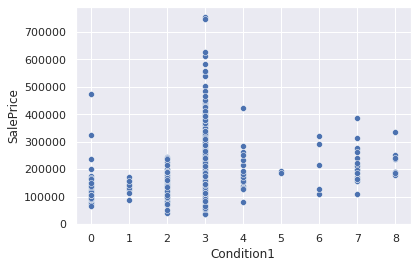

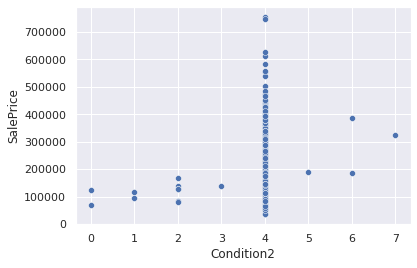

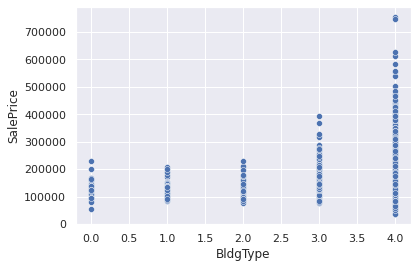

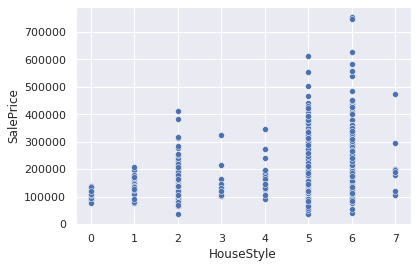

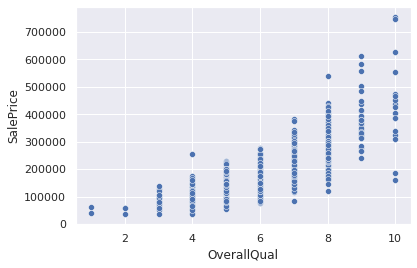

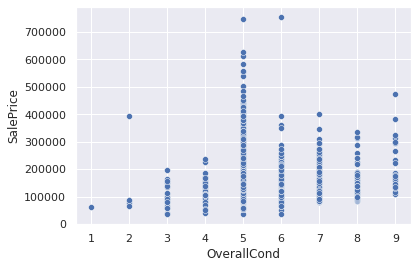

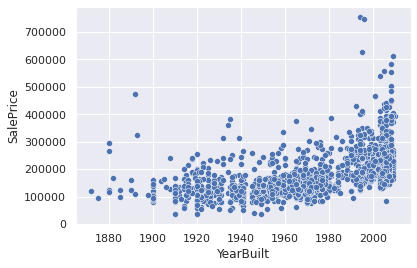

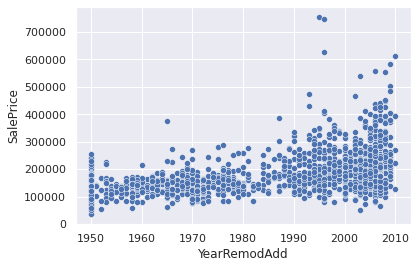

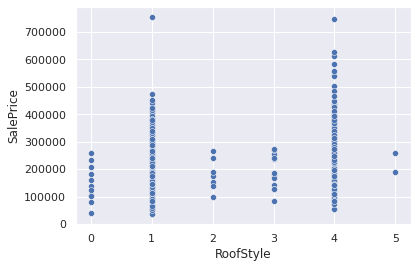

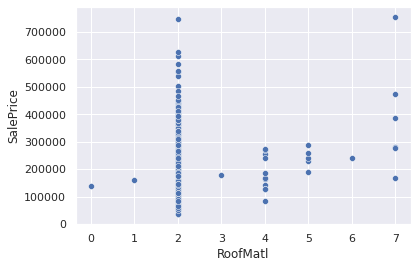

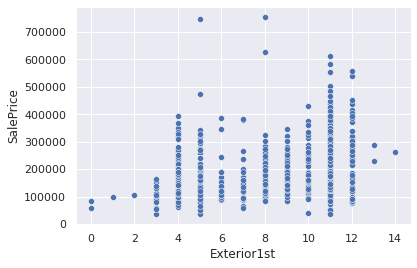

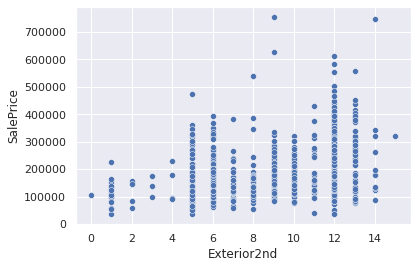

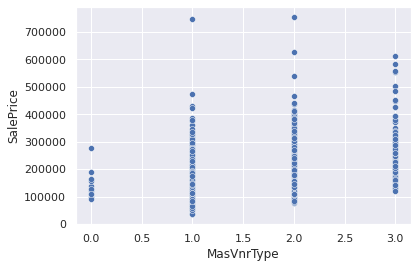

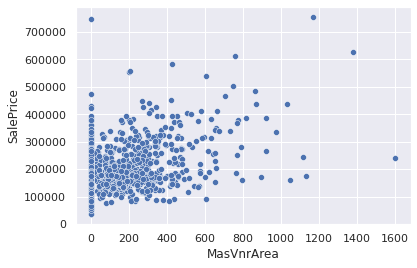

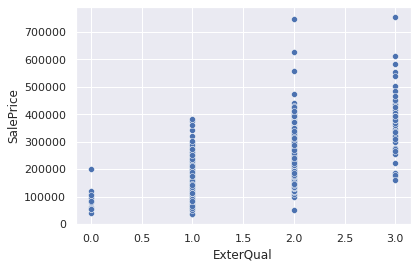

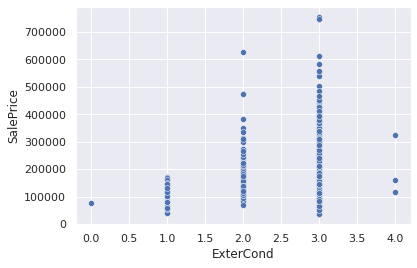

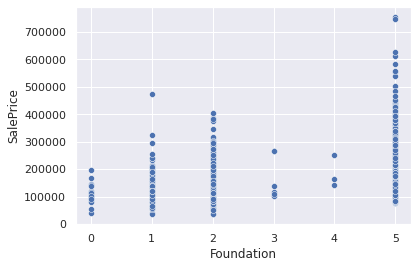

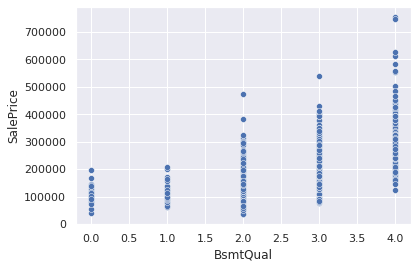

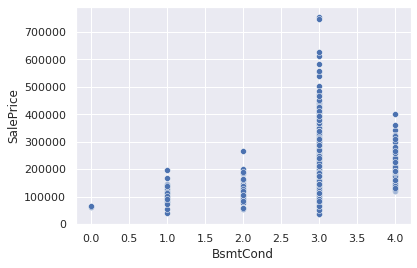

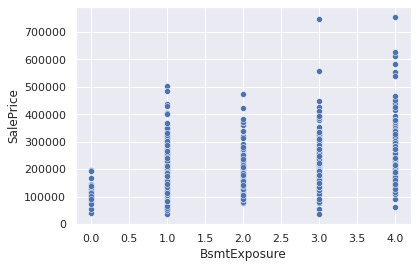

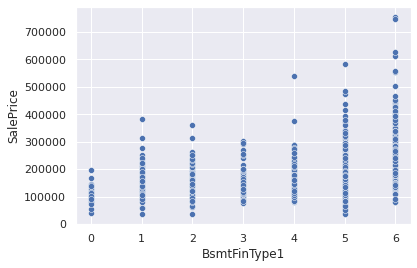

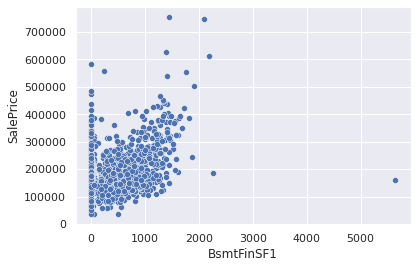

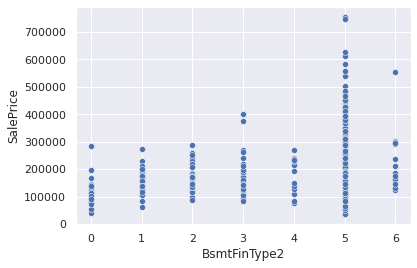

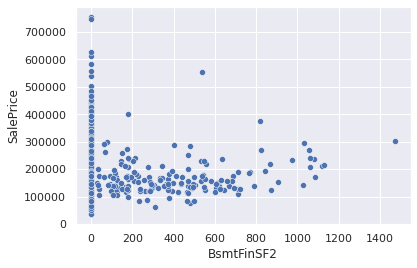

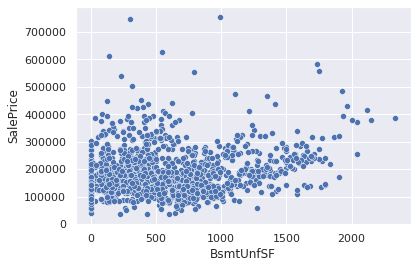

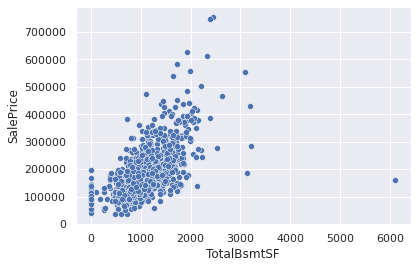

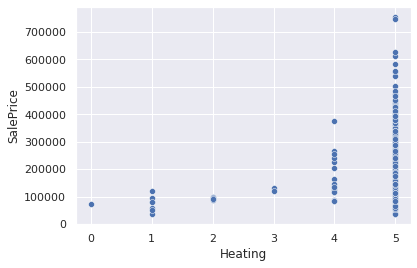

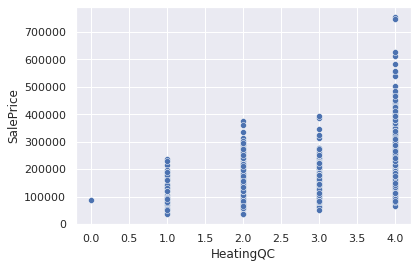

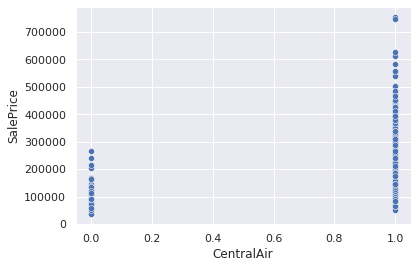

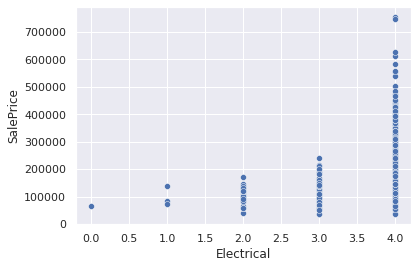

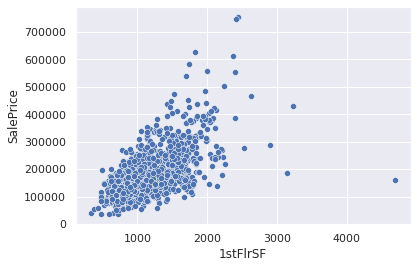

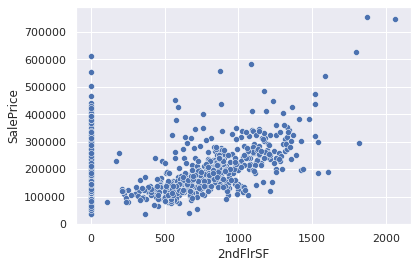

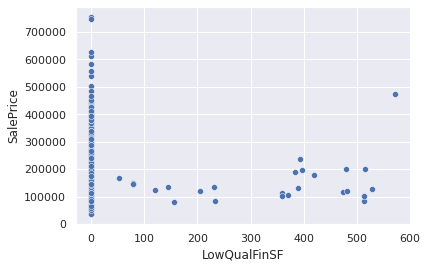

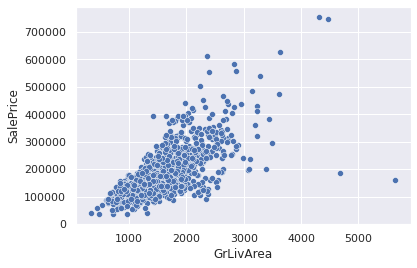

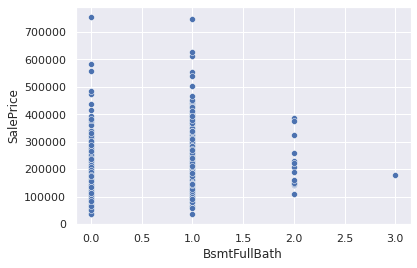

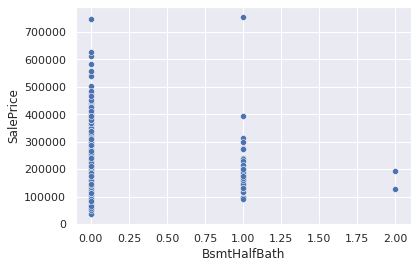

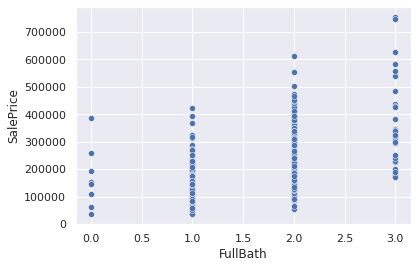

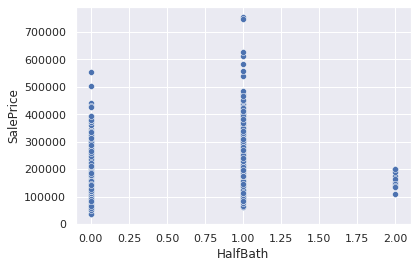

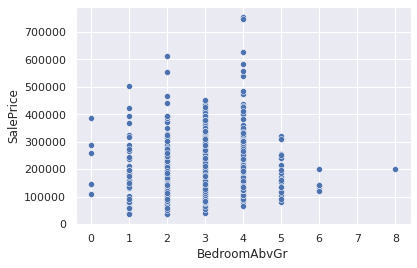

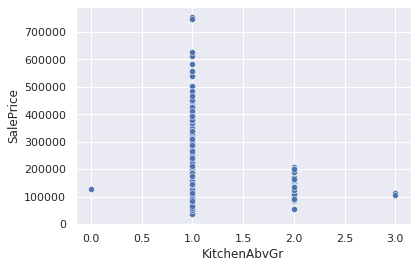

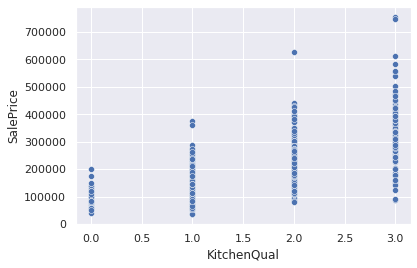

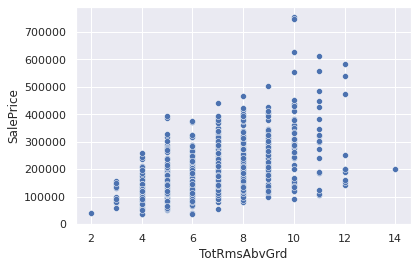

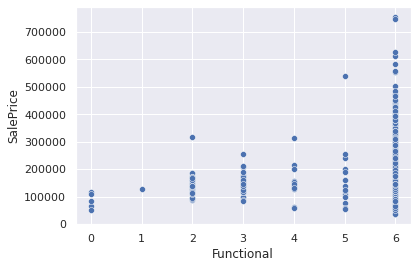

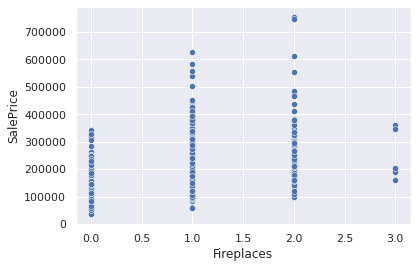

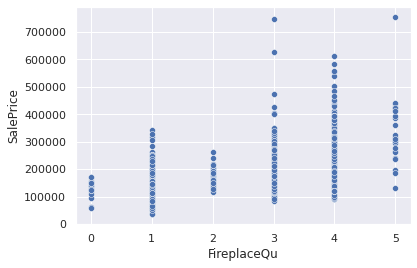

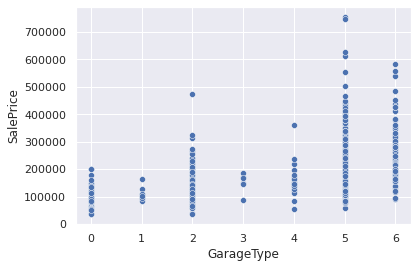

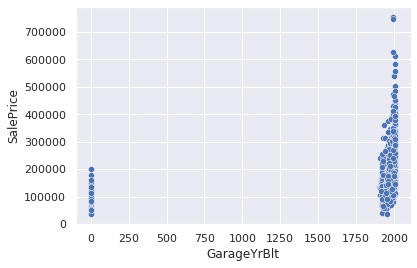

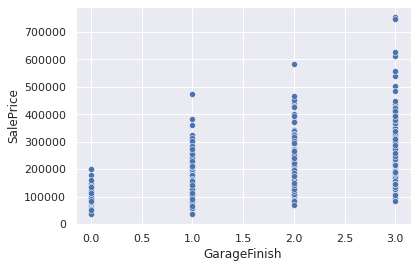

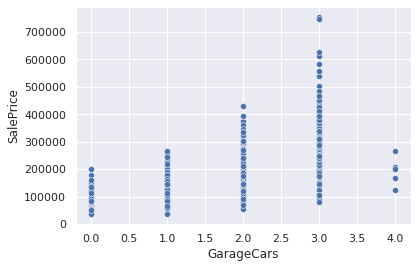

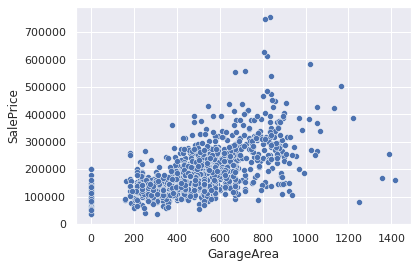

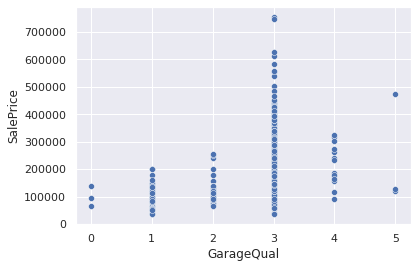

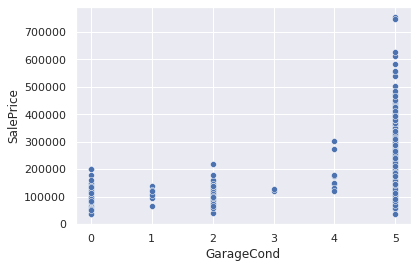

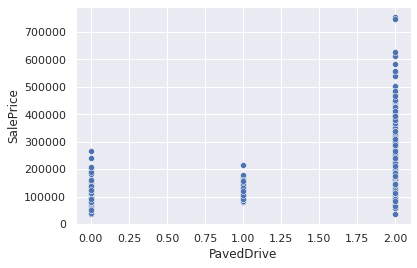

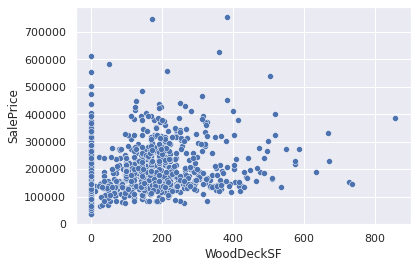

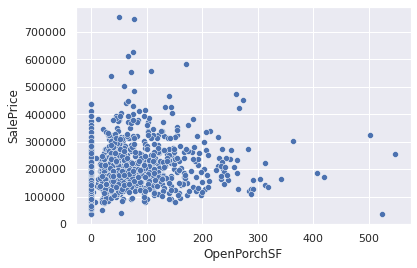

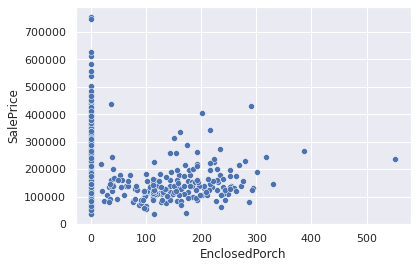

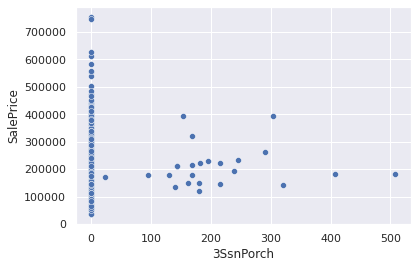

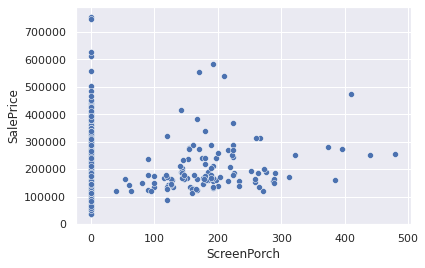

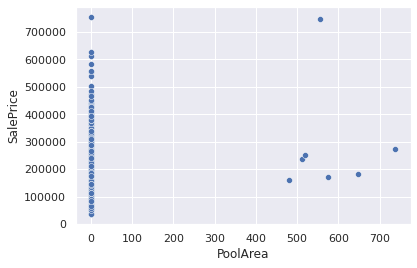

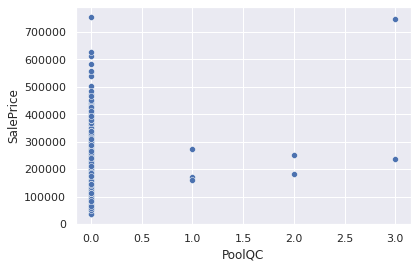

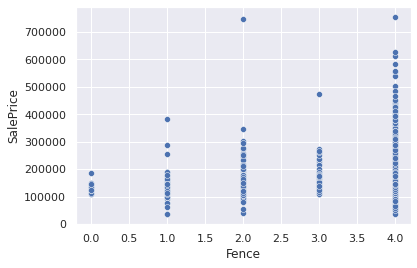

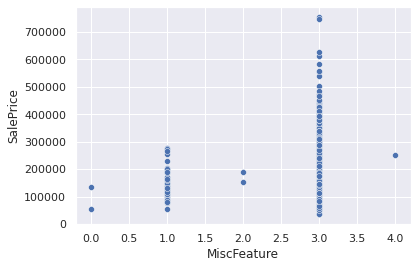

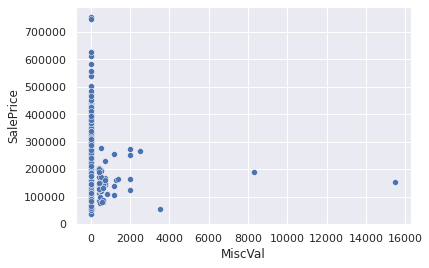

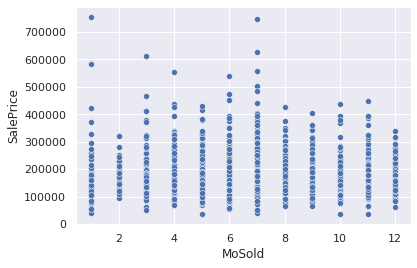

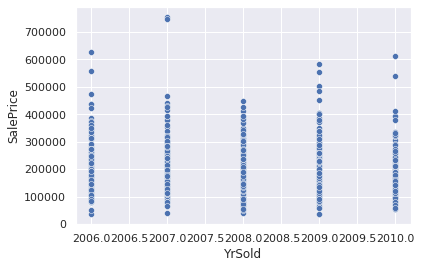

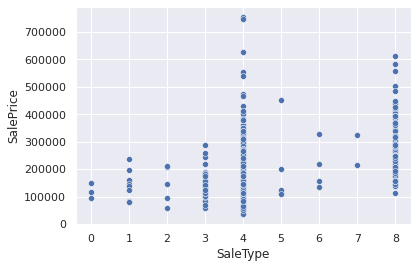

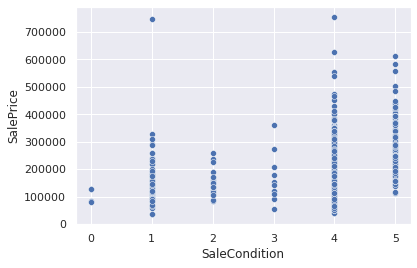

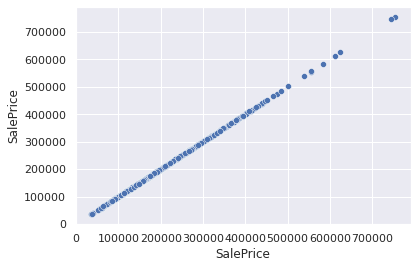

In [39]:
for i,column in enumerate(train.columns):
    if train[column].dtype != 'object':
        plt.figure(i)
        
sns.scatterplot(x=column,y='SalePrice',data=train);

### Conclusion from the charts

- MSSubClass: should be re-encoded to find a tendency between the labels (done)
- LotFrontage: drop values greater than 300
- LotArea: drop values greater than 100000
- OverallQual: drop values greater than 9 with saleprice lower than 22000
- OverallCond: ok
- YearBuilt: ok
- YearRemodAdd: ok
- MasVnrArea: ok
- BsmtFinSF1: drop values greater than 4000
- VsmtFinSF2: ok
- TotalBsmtSF: drop values greater than 5000
- 1stFlrSF: drop values greater than 4000
- 2ndFlrSF: ok
- LowQualFinSF: Almost constant, drop feature.
- GrLivArea: drop values greather than 4000 when the sale price is lower than 200000
- BsmtFullBath: Drop columns
- BsmtHalfBath: drop feature
- FullBath: ok -> Turn this feature into Baths = FullBath + 0.75* BsmtFullBath + 0.5 * HalfBath + 0.75 BsmtHalfBath
- HalfBath: drop feature
- BedroomAbvGr: ok
- KitchenAbcGr: drop
- TotRmsAbvGrd: ok
- Fireplaces: ok
- GarageYrBlt: drop
- GarageCars: ok
- GarageArea: drop values greater than 1200 and Saleprice lower than 300000
- WoodDeckSf: ok
- OpenPorch: drop values greater than 500 and SalePrice lower than 200000
- EnclosedPorch: ok
- 3SsnPorch: constant, drop feature.
- ScreenPorch: ok
- PoolArea: ok
- MiscVal: don't see much relation in this feature, drop.
- MoSold: no aparent trend, drop.
- YearSold: no aparent trend, drop.


### New features

In [73]:
train['Bath'] = train['FullBath'] + 0.75 * train['BsmtFullBath'] + 0.5 * train['HalfBath'] + 0.375 * train['BsmtHalfBath']
test['Bath'] = test['FullBath'] + 0.75 * test['BsmtFullBath'] + 0.5 * test['HalfBath'] + 0.375 * test['BsmtHalfBath']

train['Bath']

0       3.250
1       2.375
2       3.250
3       1.750
4       3.250
        ...  
1446    2.500
1447    2.750
1448    2.000
1449    1.750
1450    2.250
Name: Bath, Length: 1451, dtype: float64

### Features drop

In [74]:
# LowQualFinSF, 'BsmtFullBath', 'BsmtHalfBath', 'HalfBath', '3SsnPorch', MiscVal, 'MoSold', 'YearSold','KitchenAbvGr'
# 'GarageYrBlt'
try:
    train = train.drop(['LowQualFinSF','BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
                      '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold','KitchenAbvGr',
                       'GarageYrBlt','FullBath'],axis=1)
    test = test.drop(['LowQualFinSF','BsmtFullBath', 'BsmtHalfBath', 'HalfBath',
                      '3SsnPorch', 'MiscVal', 'MoSold', 'YrSold','KitchenAbvGr',
                       'GarageYrBlt','FullBath'],axis=1)
except:
    print('One columns does not exist.')


### Train row drops

In [75]:
# OverallQual
try:
    train=train.drop(train.loc[(train['OverallQual']>9) & (train['SalePrice']<220000)].index,0)
except:
    pass

# GrLivArea
try:
    train=train.drop(train.loc[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index,0)
except:
    pass


/tmp/ipykernel_30643/579606969.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train=train.drop(train.loc[(train['OverallQual']>9) & (train['SalePrice']<220000)].index,0)
/tmp/ipykernel_30643/579606969.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  train=train.drop(train.loc[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index,0)


In [76]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1449 entries, 0 to 1450
Data columns (total 70 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1449 non-null   int64  
 1   MSZoning       1449 non-null   int64  
 2   LotFrontage    1449 non-null   float64
 3   LotArea        1449 non-null   int64  
 4   Street         1449 non-null   int64  
 5   Alley          1449 non-null   int64  
 6   LotShape       1449 non-null   int64  
 7   LandContour    1449 non-null   int64  
 8   Utilities      1449 non-null   int64  
 9   LotConfig      1449 non-null   int64  
 10  LandSlope      1449 non-null   int64  
 11  Neighborhood   1449 non-null   int64  
 12  Condition1     1449 non-null   int64  
 13  Condition2     1449 non-null   int64  
 14  BldgType       1449 non-null   int64  
 15  HouseStyle     1449 non-null   int64  
 16  OverallQual    1449 non-null   int64  
 17  OverallCond    1449 non-null   int64  
 18  YearBuil

## Data Normalization for Numeric features

In this version i will just divide by the range.
For the case of the years variables, I will substract the min year first, because otherwise the final enconding will end with high values I.e. 1988/200 =~ 10

/tmp/ipykernel_30643/2030091313.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(i);


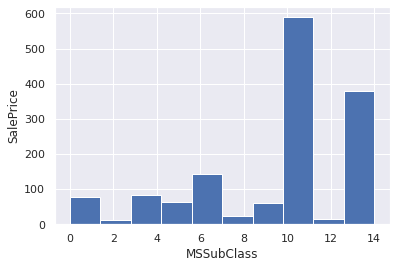

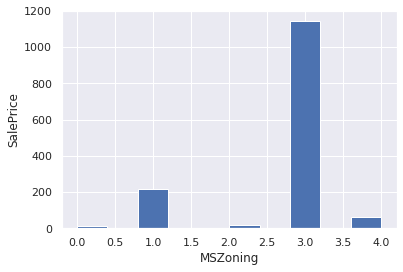

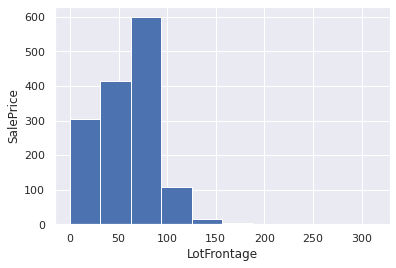

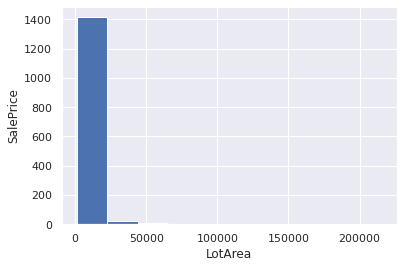

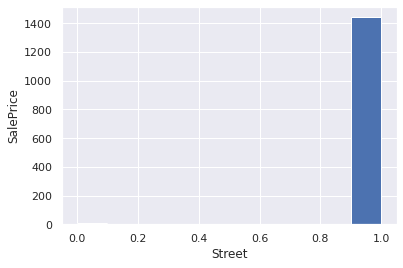

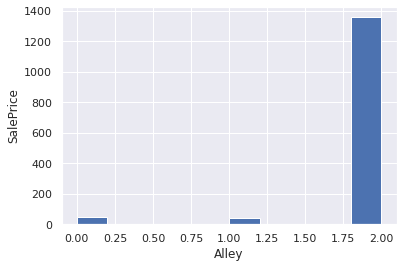

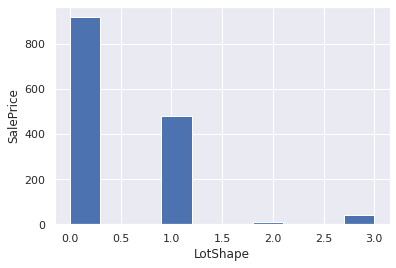

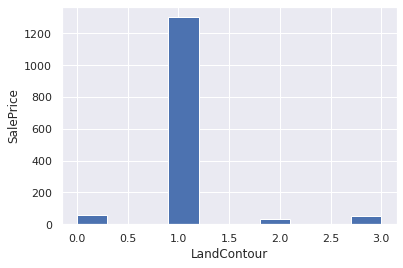

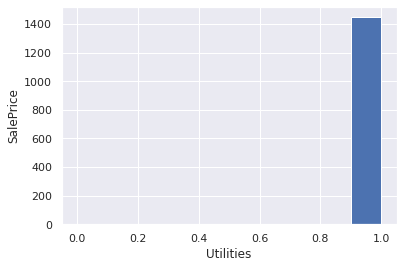

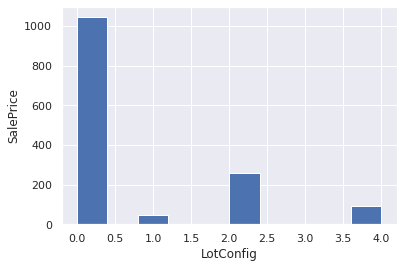

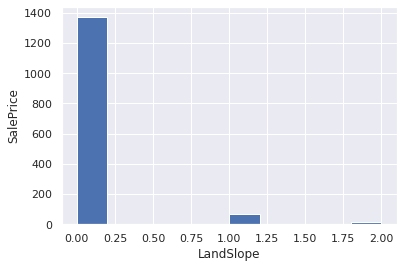

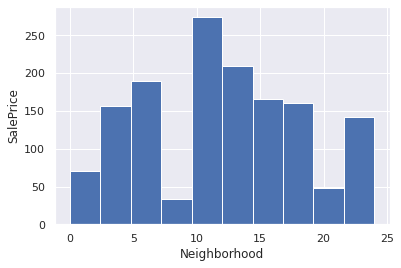

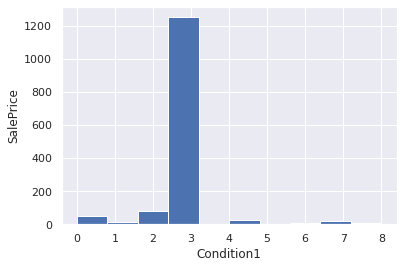

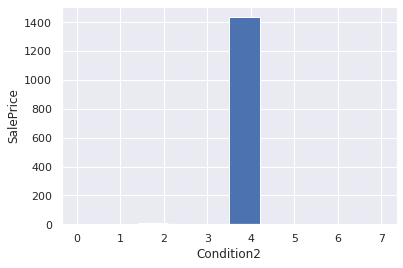

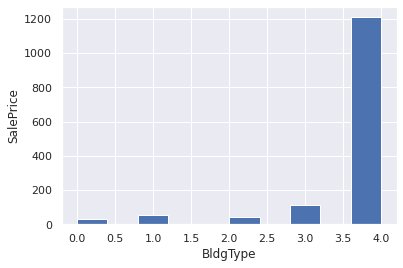

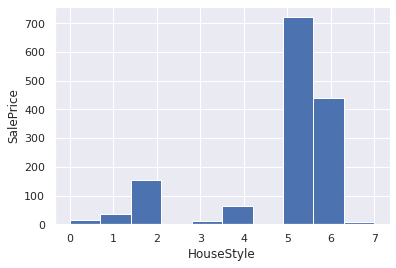

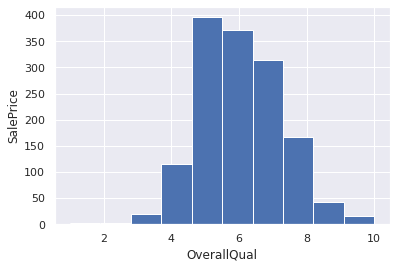

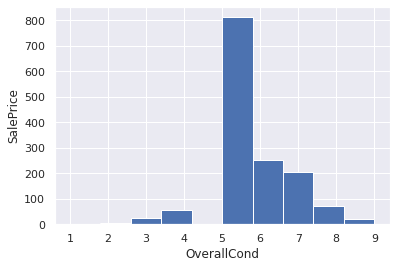

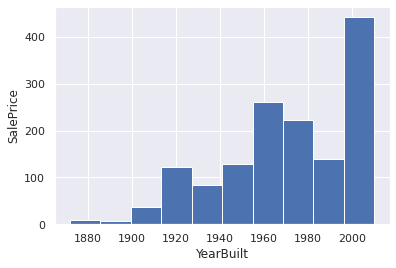

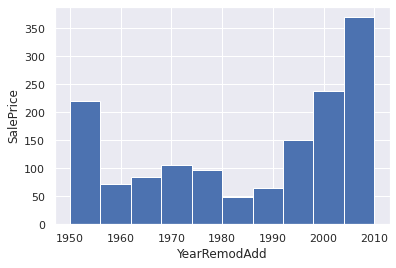

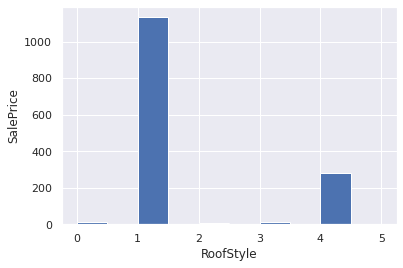

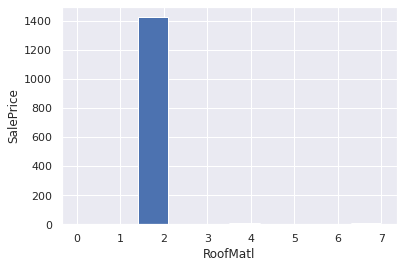

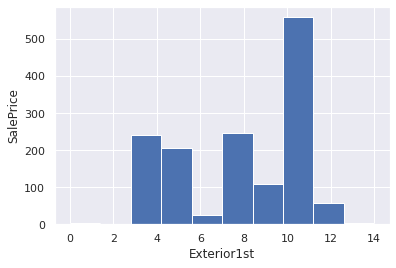

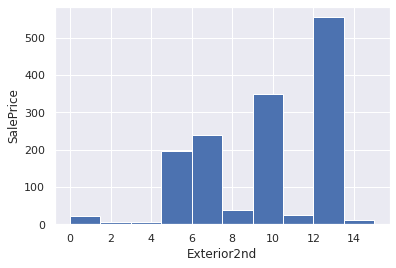

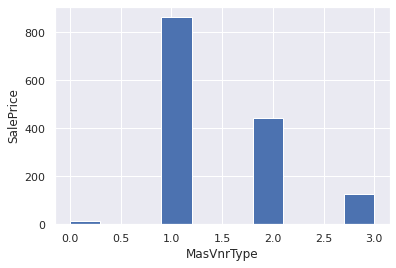

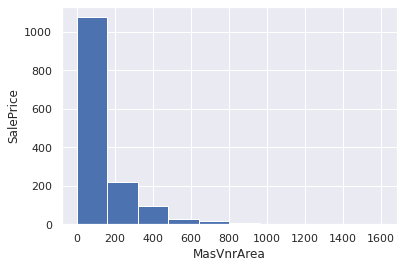

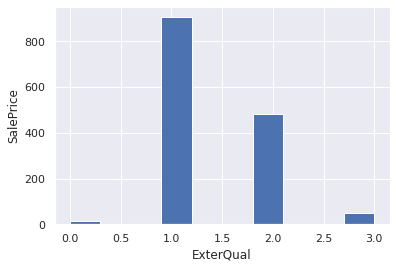

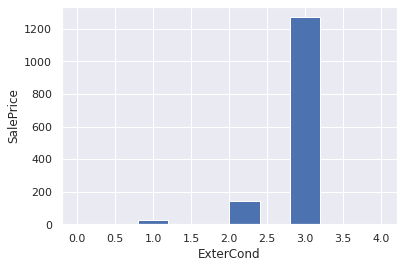

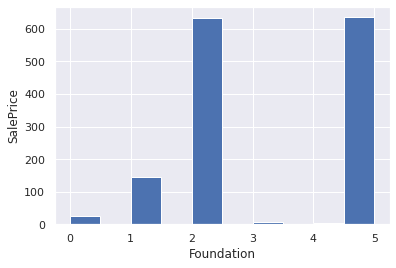

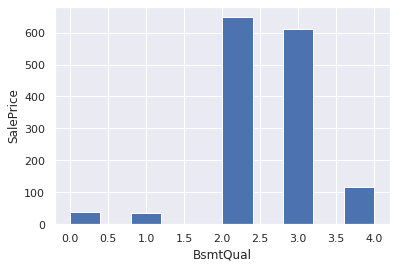

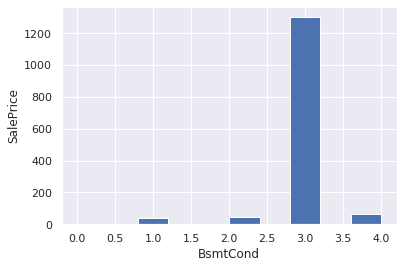

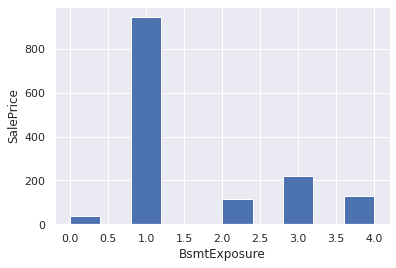

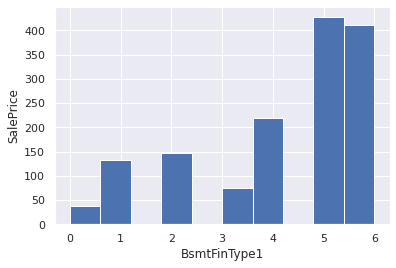

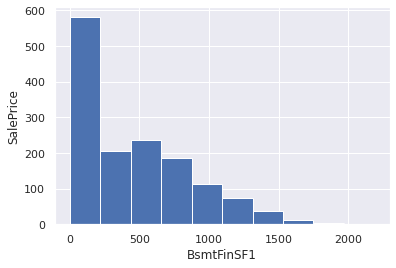

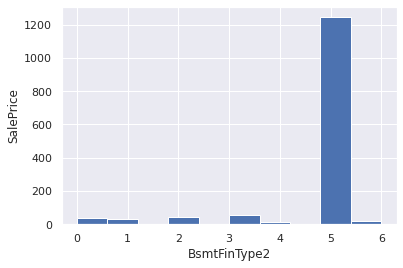

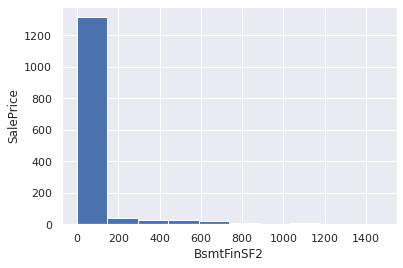

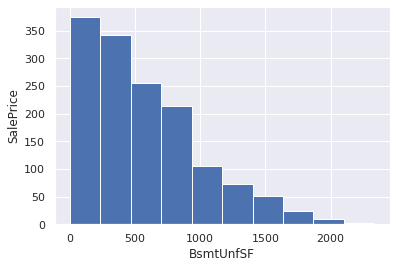

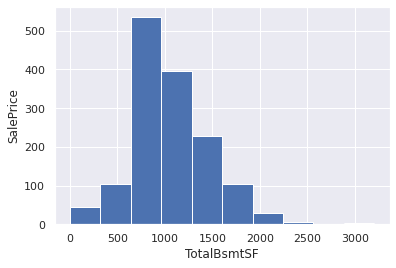

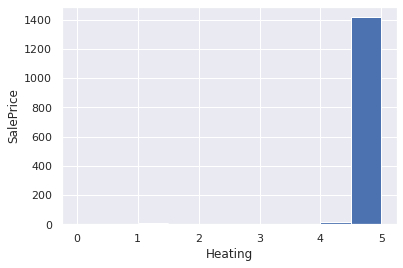

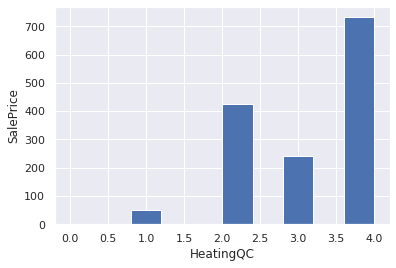

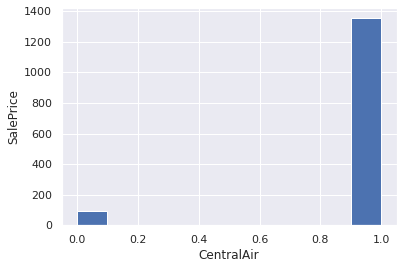

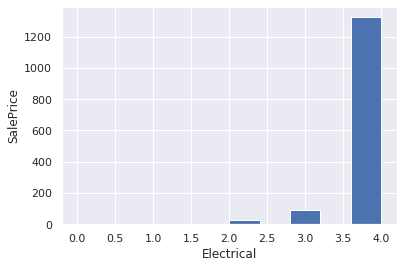

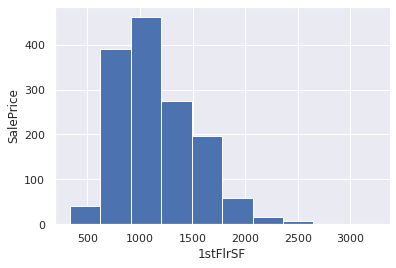

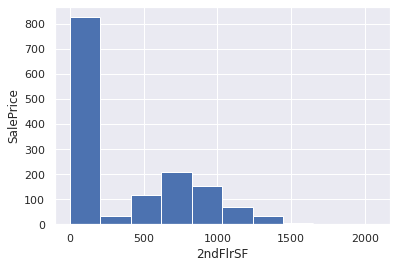

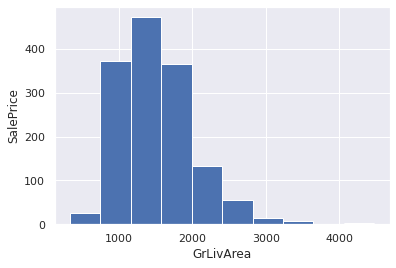

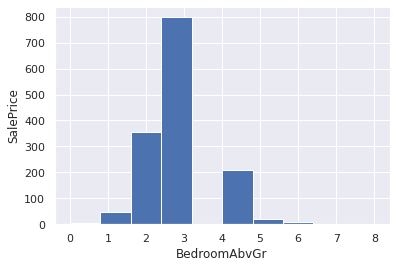

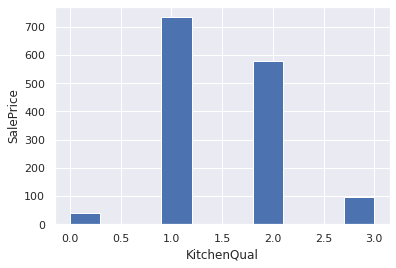

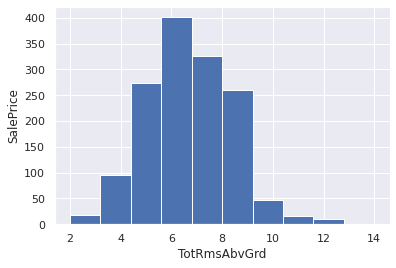

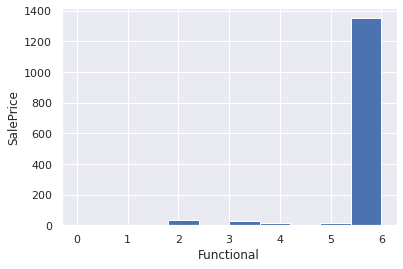

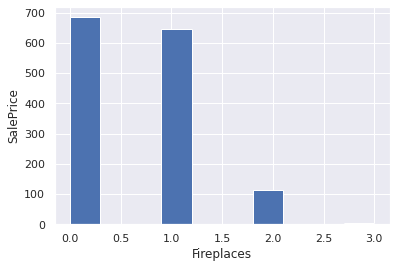

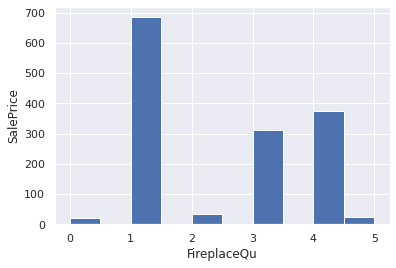

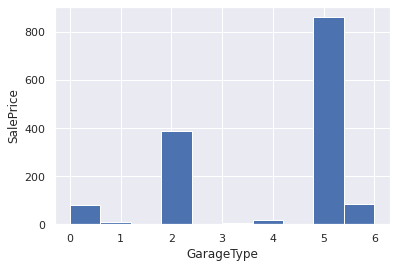

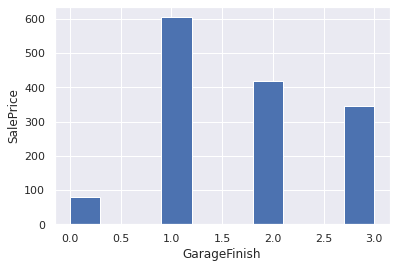

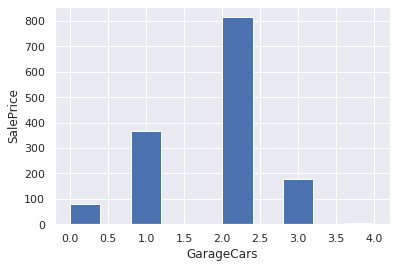

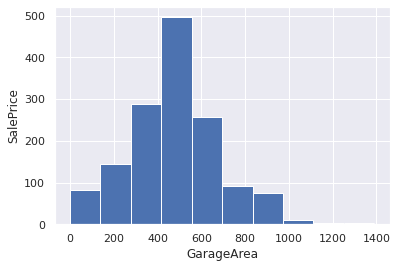

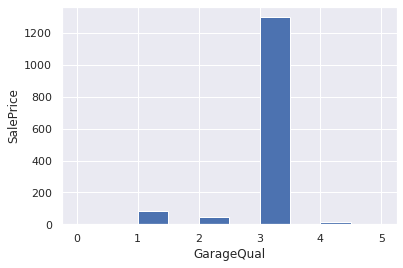

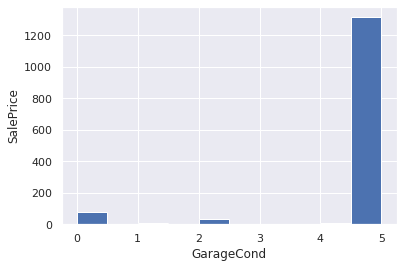

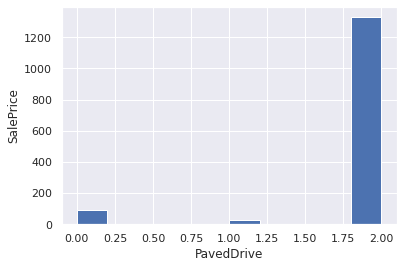

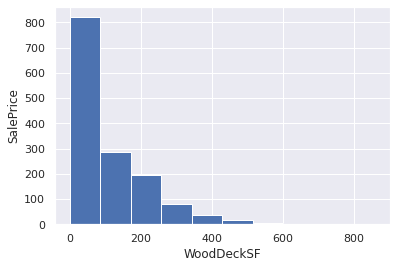

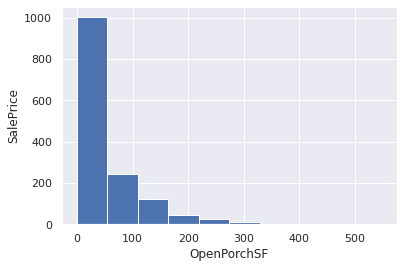

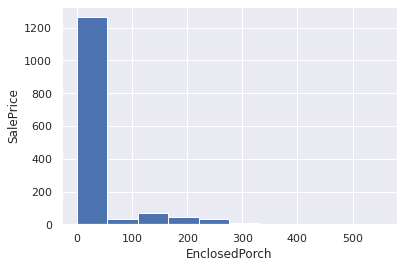

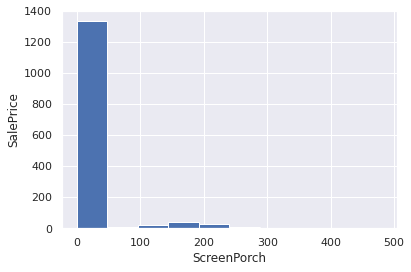

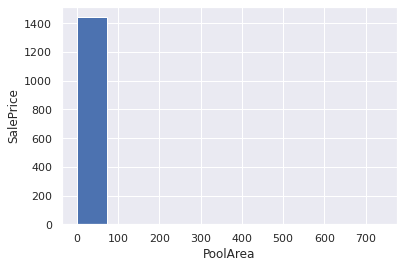

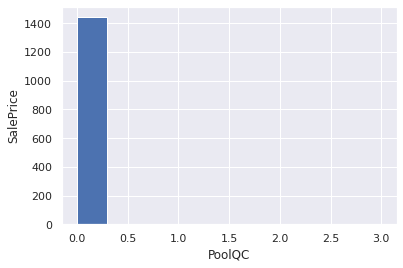

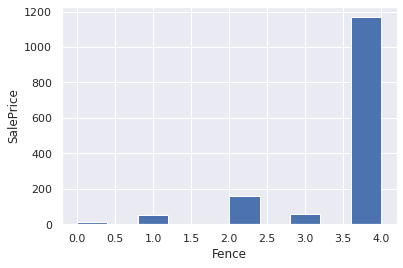

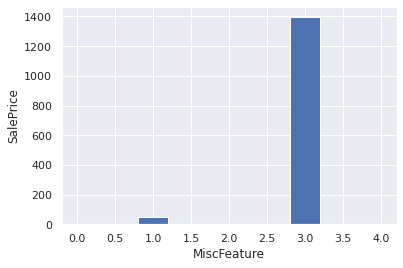

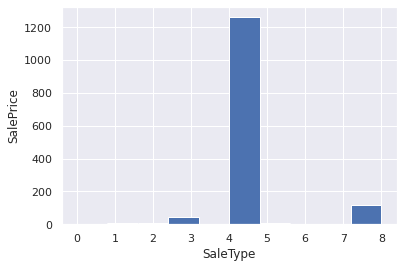

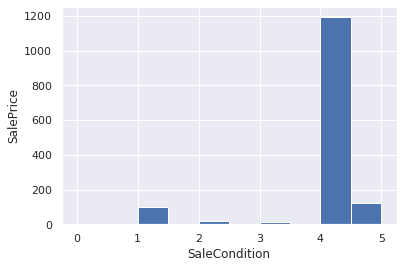

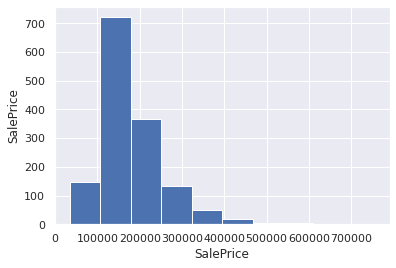

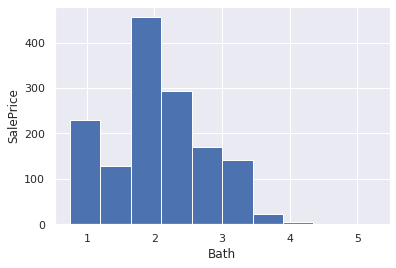

In [79]:
for i,column in enumerate(train.columns):
    if train[column].dtype != 'object':
        plt.figure(i);
        train[column].hist();
        plt.ylabel("SalePrice")
        plt.xlabel(column)
        

In [82]:
train['YearBuilt'].min()+(train['YearBuilt'].max()-train['YearBuilt'].min())/2

0.5

In [83]:
rang_dict = dict()

train['YearBuilt'] = train['YearBuilt'] - train['YearBuilt'].min()
train['YearRemodAdd'] = train['YearRemodAdd'] - train['YearRemodAdd'].min()
test['YearBuilt'] = test['YearBuilt'] - test['YearBuilt'].min()
test['YearRemodAdd'] = test['YearRemodAdd'] - test['YearRemodAdd'].min()

for column in train.columns.drop('SalePrice'):
    rang = train[column].max()-train[column].min()
    train[column] = train[column].div(rang)
    test[column] = test[column].div(rang) 
    rang_dict[column] = rang
    

## Feature correlation

In [84]:
corr = train.corr().sort_values(by='SalePrice',ascending=False).round(2)
corr['SalePrice'].head(16)

SalePrice       1.00
OverallQual     0.79
GrLivArea       0.74
Neighborhood    0.70
ExterQual       0.69
KitchenQual     0.66
Bath            0.66
TotalBsmtSF     0.65
GarageCars      0.64
1stFlrSF        0.63
GarageArea      0.63
BsmtQual        0.62
GarageFinish    0.55
TotRmsAbvGrd    0.54
FireplaceQu     0.53
YearBuilt       0.52
Name: SalePrice, dtype: float64

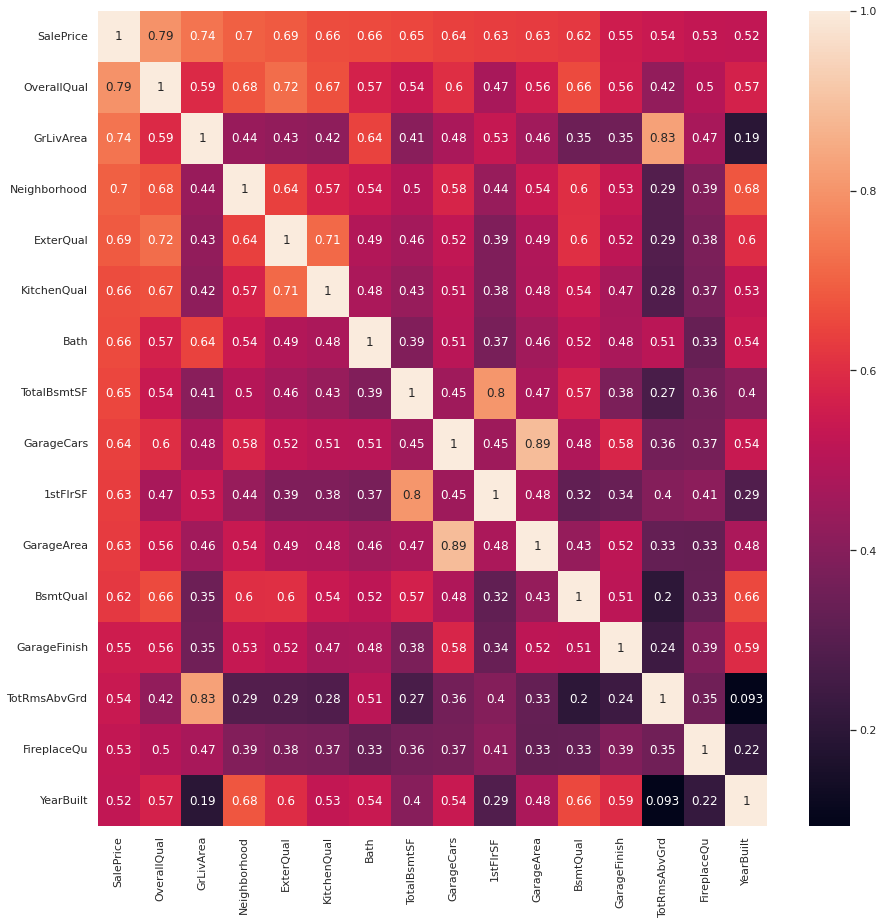

<Figure size 432x288 with 0 Axes>

In [88]:
# heatmap of the 15 most correlated features
plt.figure(figsize=(15,15))
cols =corr['SalePrice'].head(16).index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1)
hm = sns.heatmap(cm, annot=True, yticklabels=cols.values, xticklabels=cols.values)
plt.show()
plt.savefig('MRF_heatmap.png')

## Most relevant features

The most relevant features were obtained from the RLR model, accoding to the weights of each feature.
For this features, 2nd 3rd and 4th order powers will be added.

In [89]:
mrf = list(corr['SalePrice'].head(16).index)[1:]
mrf

['OverallQual',
 'GrLivArea',
 'Neighborhood',
 'ExterQual',
 'KitchenQual',
 'Bath',
 'TotalBsmtSF',
 'GarageCars',
 '1stFlrSF',
 'GarageArea',
 'BsmtQual',
 'GarageFinish',
 'TotRmsAbvGrd',
 'FireplaceQu',
 'YearBuilt']

In [92]:
# Adding some powers to the mrf

for feature in mrf:
    for power in [2,3,4]:
        new_f = feature +'_' +str(power)
        train[new_f] = train[feature]**power
        test[new_f] = test[feature]**power


/tmp/ipykernel_30643/3673757419.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  test[new_f] = test[feature]**power


In [93]:
train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,GarageFinish_4,TotRmsAbvGrd_2,TotRmsAbvGrd_3,TotRmsAbvGrd_4,FireplaceQu_2,FireplaceQu_3,FireplaceQu_4,YearBuilt_2,YearBuilt_3,YearBuilt_4
0,1.000000,0.75,0.207668,0.039496,1.0,1.0,0.000000,0.333333,1.0,0.00,...,0.197531,0.444444,0.296296,0.197531,0.04,0.008,0.0016,0.901124,0.855415,0.812024
1,0.785714,0.75,0.255591,0.044871,1.0,1.0,0.000000,0.333333,1.0,0.25,...,0.197531,0.250000,0.125000,0.062500,0.36,0.216,0.1296,0.567948,0.428019,0.322565
2,1.000000,0.75,0.217252,0.052584,1.0,1.0,0.333333,0.333333,1.0,0.00,...,0.197531,0.250000,0.125000,0.062500,0.36,0.216,0.1296,0.873819,0.816830,0.763559
3,0.642857,0.75,0.191693,0.044638,1.0,1.0,0.333333,0.333333,1.0,0.50,...,0.012346,0.340278,0.198495,0.115789,0.64,0.512,0.4096,0.097091,0.030253,0.009427
4,1.000000,0.75,0.268371,0.066653,1.0,1.0,0.333333,0.333333,1.0,0.25,...,0.197531,0.562500,0.421875,0.316406,0.36,0.216,0.1296,0.860323,0.797981,0.740156


In [94]:
#train.hist(bins=25, figsize=(20,60), layout=(17,5));

# Save data

In [39]:
import json

train.to_csv('../data/train_fe_v2_2.csv')
test.to_csv('../data/test_fe_v2_2.csv')

# create json object from dictionary
json = json.dumps(rang_dict)

# open file for writing, "w" 
f = open("rang_dict.json","w")

# write json object to file
f.write(json)

# close file
f.close()

